# Collaboration and Competition

---
###          Deep Reinforcement Learning Nano-degree - Udacity
###                  Created/Modified on: December 5th, 2018
###                      Author: Munir Jojo-Verge
---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment

import numpy as np
import random
import torch
import numpy as np
import os.path
from collections import deque
import matplotlib.pyplot as plt
import time
import argparse
from datetime import datetime

%matplotlib inline

#### 1.1 Import the python files developed for this project
You'll find all the code in the following files.
* ddpg_agent.py: In this file we have 2 classes defined:
    * Agent class: That implements the DDPG algorithm
    * ReplayBuffer: This is a very simple Replay Mememory class to basicaly store and sample the "Transisions" (state,action, next_state, reward, done)
* memory.py: In this file I developed a more sophisticated Priority Replay Memory Class based on the "Rainbow" development.
* model.py: Defines the Actor/Critic Neural Networks (with 4 hidden layers and 96x96 filters)
* model2.py: Defines the Actor/Critic Neural Networks (with 3 hidden layers and 96x96 filters) - This one ended up being sufficient and even performed better.(Read Report.pdf for more details)

In [2]:
from ddpg_agent import Agent, ReplayBuffer
from memory import ReplayMemory

### 2. Define the arguments that we will use to configure/define the Cov Nets and the algoritm's behavior
This is a comprehensive list of arguments that will serve as a fundation for both, the single agent and the multiple agent. Also we will use some of this arguments to define how the DDPG algorithm will behave.

In [3]:
class args:
    seed = 777                      # Random seed
    disable_cuda = False            # Disable CUDA
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #game = '/media/munirjojo-verge/My Passport/01 - Deep Learning Nanodegree/deep-reinforcement-learning/p2_continuous-control/Reacher_Linux_NoVis/Reacher.x86_64' # Udacity environment        
    game = '/media/munirjojo-verge/My Passport/01 - Deep Learning Nanodegree/deep-reinforcement-learning/p3_collab-compet/Tennis_Linux/Tennis.x86_64'
    T_max = int(1e3)                # Number of training steps
    max_num_episodes = int(1000)     # Max number of episodes      
    
    hidden_1_size = 96              # Network hidden layer 1 size
    hidden_2_size = 96              # Network hidden layer 2 size
    hidden_3_size = 96              # Network hidden layer 3 size
    
    noise_std = 0.05               # Initial standard deviation of noise added to weights
    
    memory_capacity = int(1e6)      # Experience replay memory capacity
    batch_size = 256*1             # Batch size: Number of memories will be sampled to learn 
    learning_starts_ratio = 1/50   # Number of steps before starting training = memory capacity * this ratio
    learning_frequency = 2    # Steps before we sample from the replay Memory again    
    
    priority_exponent = 0.5         # Prioritised experience replay exponent (originally denoted α)
    priority_weight = 0.4           # Initial prioritised experience replay importance sampling weight
    
    discount = 0.99                 # Discount factor
    
    target_update = int(30)          # Number of steps after which to update target network (Soft update for Actor & Critic)
    tau = 1e-3                      # Soft Update interpolation parameter
    
    reward_clip = 1                 # Reward clipping (0 to disable)
    
    lr_Actor = 1e-3                 # Learning rate - Actor
    lr_Critic = 1e-3                # Learning rate - Critic
    adam_eps = 1e-08                # Adam epsilon (Used for both Networks)
    weight_decay = 0                # Critic Optimizer Weight Decay
        

### 3. Setup the platform where we'll run

Using some of the arguments above we can setup some of our platform parameters

In [4]:
random.seed(args.seed)
torch.manual_seed(random.randint(1, 10000))
if torch.cuda.is_available() and not args.disable_cuda:
  args.device = torch.device('cuda')
  torch.cuda.manual_seed(random.randint(1, 10000))
  torch.backends.cudnn.enabled = False  # Disable nondeterministic ops (not sure if critical but better safe than sorry)
else:
  args.device = torch.device('cpu')

### 4. Create the Environment - Unity

In [5]:
env = UnityEnvironment(file_name = args.game)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 5. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])
print('The state for the second agent looks like:', states[1])
print('Number of agents:', len(states))

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]
The state for the second agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.4669857  -1.5         0.          0.
 -6.83172083  6.          0.          0.        ]
Number of agents: 2


### 6. Create an instance of our DDPG Agent

In [8]:
# Construct the Agent
agent = Agent(args,state_size=state_size, action_size=action_size)

# Replay memory: We create the Replay Mem outside the Agent so we can share 1 single Mem with all 20 agents. 
# I will try the simple replay buffer and a more sophisticated priority replay memory.
#memory = ReplayMemory(args)
memory = ReplayBuffer(action_size, args.memory_capacity, args.batch_size, args.seed)

In [10]:
# DDPG

def ddpg(agent, memory, StopWhenSolved = False):
    if os.path.isfile('weights/actor_final.pth'):
        agent.actor_local.load_state_dict(torch.load('weights/actor_final.pth'))
        agent.critic_local.load_state_dict(torch.load('weights/critic_final.pth'))

    
    ######################
    last100_best_scores_deque = deque(maxlen=100)
    scores_global = []
    average_global = []
    min_global = []
    max_global = []
    time_taken = 0
    Start_time = time.time()
    #######################
        
    for i_episode in range(1, agent.args.max_num_episodes):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        agent.reset()
        
        timestep = 0
        dones = np.zeros(num_agents) 
        while timestep <= agent.args.T_max:                    # while any agents has NOT reached the ball (done)
            timestep += 1 
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to the environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished    
                        
            agent.memorize(states, actions, rewards, next_states, dones, memory)
            
            agent.learn(memory,timestep)
                        
            states = next_states
            scores += rewards            
                    
        episode_avg_score = np.mean(scores)                
        scores_global.append(episode_avg_score)
                
        min_global.append(np.min(scores))  
        max_global.append(np.max(scores)) 
        
        last100_best_scores_deque.append(max_global[len(max_global)-1])        
        last100_best_scores_average = np.mean(last100_best_scores_deque)
        
        
        print('\rEpisode {} \tlast 100 avg: {:.2f} \tavg score: {:.2f} '.format(i_episode, last100_best_scores_average, episode_avg_score), end="")
        if i_episode % 10 == 0:
            torch.save(agent.actor_local.state_dict(), 'weights/checkpoint_actor_eps' + str(i_episode) + '.pth')
            torch.save(agent.critic_local.state_dict(), 'weights/checkpoint_critic_eps'+ str(i_episode) + '.pth')
            print('\rEpisode {} \tlast 100 avg: {:.2f}'.format(i_episode, last100_best_scores_average)) 
        
        if  (StopWhenSolved and last100_best_scores_average >= 0.5):            
            End_time = time.time()
            time_taken = (End_time - Start_time)/60
            print('\nSolved in {:d} episodes!\tlast100_best_scores_average: {:.2f}, time taken(min): {}'.
                  format(i_episode, last100_best_scores_average, (End_time - Start_time)/60))
            torch.save(agent.actor_local.state_dict(), 'weights/actor_final.pth')
            torch.save(agent.critic_local.state_dict(), 'weights/critic_final.pth')            
            break
     
    return scores_global, average_global, max_global, min_global, time_taken

scores_global, average_global, max_global, min_global, time_taken = ddpg(agent, memory)

Episode 10 	last 100 avg: 2.40 	avg score: 2.60 
Episode 20 	last 100 avg: 2.51 	avg score: 2.54 
Episode 30 	last 100 avg: 2.53 	avg score: 2.44 
Episode 40 	last 100 avg: 2.54 	avg score: 2.54 
Episode 50 	last 100 avg: 2.52 	avg score: 2.54 
Episode 60 	last 100 avg: 2.51 	avg score: 2.49 
Episode 70 	last 100 avg: 2.51 	avg score: 2.49 
Episode 80 	last 100 avg: 2.51 	avg score: 2.39 
Episode 90 	last 100 avg: 2.52 	avg score: 2.60 
Episode 100 	last 100 avg: 2.52 	avg score: 2.22 
Episode 110 	last 100 avg: 2.52 	avg score: 2.60 
Episode 120 	last 100 avg: 2.51 	avg score: 2.37 
Episode 130 	last 100 avg: 2.50 	avg score: 2.54 
Episode 140 	last 100 avg: 2.50 	avg score: 2.59 
Episode 150 	last 100 avg: 2.51 	avg score: 2.49 
Episode 160 	last 100 avg: 2.52 	avg score: 2.54 
Episode 170 	last 100 avg: 2.52 	avg score: 2.60 
Episode 180 	last 100 avg: 2.53 	avg score: 2.55 
Episode 190 	last 100 avg: 2.53 	avg score: 2.60 
Episode 200 	last 100 avg: 2.54 	avg score: 2.60 
Episode 2

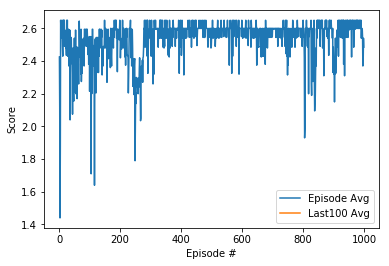

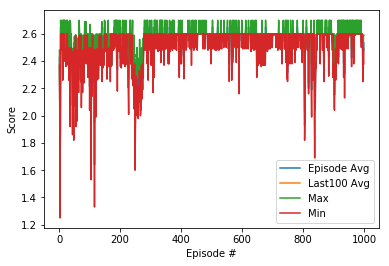

In [12]:
#fig = plt.figure()
#ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_global)+1), scores_global)
plt.plot(np.arange(1, len(average_global)+1), average_global)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['Episode Avg', 'Last100 Avg'], loc='lower right')
plt.show()

#fig2 = plt.figure()
#ax = fig.add_subplot(211)
plt.plot(np.arange(1, len(scores_global)+1), scores_global)
plt.plot(np.arange(1, len(average_global)+1), average_global)
plt.plot(np.arange(1, len(max_global)+1), max_global)
plt.plot(np.arange(1, len(min_global)+1), min_global)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend(['Episode Avg','Last100 Avg', 'Max', 'Min'], loc='lower right')
plt.show()

In [13]:
torch.save(agent.actor_local.state_dict(), 'weights/actor_final.pth')
torch.save(agent.critic_local.state_dict(), 'weights/critic_final.pth') 

In [14]:
agent.actor_local.load_state_dict(torch.load('weights/actor_final.pth'))
agent.critic_local.load_state_dict(torch.load('weights/critic_final.pth'))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
play_scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)
    #env.render()
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    play_scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(play_scores)))

env.close()

Total score (averaged over agents) this episode: 2.600000038743019


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```